## Disitizer エネルギースペクトル測定

In [1]:
#モジュールのインポート
import os
import glob
import datetime
import tkinter
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Model, Parameters, Parameter
from lmfit.models import GaussianModel,ConstantModel,LorentzianModel

In [3]:
##関数  
#ガウシアンモデル  
def gauss(x,c,amplitude,center,sigma):
    out = amplitude / (sigma*np.sqrt(2*np.pi)) * np.exp(-(x - center)**2 /(2 * sigma**2)) + c
    return out

#ローレンチアンモデル  
def lorentz(x,c,amplitude,center,sigma):
    out = amplitude / np.pi * (sigma/((x-center)**2 + sigma**2)) + c
    return out
    
#ヒストグラムのクラス   
class Histodata():
    def __init__(self,signal,noise,bins,filename):
        self.name  = filename
        #ノイズのベースライン測定  
        nCount, level = np.histogram(noise,bins=bins)
        nLevel = np.array([])
        for num in range(1,len(level)):
            nLevel = np.append(nLevel,(level[num-1]+level[num])/2)
        self.nCount = nCount
        self.nLevel = nLevel
        
        nmod = GaussianModel()
        par = nmod.guess(nCount,x=nLevel)
        self.noise = nmod.fit(nCount,par,x=nLevel)
        #  
        
        yarr,level = np.histogram(signal-self.noise.values['center'],bins=bins)#ヒストグラム作成  
        xarr = np.array([])
        for num in range(1,len(level)):
            xarr = np.append(xarr,(level[num-1]+level[num])/2)
        self.count = yarr
        self.level = xarr

        
        dir0 = os.getcwd()
        path = os.path.join(dir0,'plot')
        res1 = dir0 == path
        res2 = os.path.exists(path)
        if (res1==0) & (res2==0):
            os.mkdir(path)
        os.chdir(path)
        

        #パラメータ初期化  
        pars = Parameters()
        ix = np.where(self.count == self.count.max())[-1]
        pars['c'] = Parameter(name='c',value=0,vary=True)
        pars['amplitude'] = Parameter(name='amplitude',value=np.pi*self.count.max()*(self.level.max()-self.level.min())/20,vary=True)
        pars['center'] = Parameter(name='center',value=self.level[ix][0],vary=True)
        pars['sigma'] = Parameter(name='sigma',value=(self.level.max()-self.level.min())/20,vary=True)
        pars['height'] = Parameter(name='height',expr='amplitude/sigma/pi',vary=False)
        pars['sn'] = Parameter(name='sn',expr= 'center/'+str(self.noise.values['sigma']),vary=False)        
        self.pars = pars
                
        self.gmod, self.gfit = self.gaussfit(self.level,self.count,self.pars,fname=self.name,save=True)
        self.lmod, self.lfit = self.lorentzfit(self.level,self.count,pars,fname=self.name,save=True)
        
        os.chdir(dir0)
    def plot(self,save=False):
        plt.plot(self.level,self.count,marker='.',color='tab:blue',linestyle='None',label='measured')
        plt.xlabel('voltage[mV]',fontsize=16)
        plt.ylabel('bins count',fontsize=16)
        plt.legend()
        plt.tight_layout()
        if save==True:
            plt.savefig(self.name+'.png')
        plt.show()
    
    def lorentzfit(self,x,y,pars,fname='tuned',save=False):
        if pars == None:
            mod = LorentzianModel()
            pars = mod.guess(y,x=x)
        else:
            mod = Model(lorentz)
            pars['fwhm'] = Parameter(name='fwhm',expr="2*sigma",vary=False)
            pars['resolution'] = Parameter(name='resolution',expr='center/fwhm',vary=False)
            
        result = mod.fit(y, pars, x=x)
        
        fit = mod.func(self.level,
                       result.best_values['c'],
                       result.best_values['amplitude'],
                       result.best_values['center'],
                       result.best_values['sigma'])
        plt.plot(self.level,fit,color='tab:orange',label='LorentzianFit')
        plt.plot(self.level,self.count,marker='.',color='tab:blue',linestyle='None',label='measured')
        plt.xlabel('voltage[mV]',fontsize=16)
        plt.ylabel('bins count',fontsize=16)
        plt.legend()
        plt.tight_layout()
        if save==True:
            if fname == 'tuned':
                fname = 'tuned_'+self.name
            plt.savefig(fname+'_Lfit.png')
        plt.show()
        return mod, result
    
    def gaussfit(self,x,y,pars,fname='tuned',save=False):
        if pars == None:
            mod = GaussianModel()
            pars = mod.guess(y,x=x)
        else:
            mod = Model(gauss)
            pars['fwhm'] = Parameter(name='fwhm',expr=str(np.sqrt(2*np.log(2)))+"*2*sigma",vary=False)
            pars['resolution'] = Parameter(name='resolution',expr='center/fwhm',vary=False)
            
        result = mod.fit(y, pars, x=x)
        
        fit = mod.func(self.level,
               result.best_values['c'],
               result.best_values['amplitude'],
               result.best_values['center'],
               result.best_values['sigma'])
        plt.plot(self.level,fit,color='tab:orange',label='GaussianFit')
        plt.plot(self.level,self.count,marker='.',color='tab:blue',linestyle='None',label='measured')
        plt.xlabel('voltage[mV]',fontsize=16)
        plt.ylabel('bins count',fontsize=16)
        plt.legend()
        plt.tight_layout()
        if save==True:
            if fname == 'tuned':
                fname = 'tuned_'+self.name
            plt.savefig(fname+'_Gfit.png')
        plt.show()
        return mod, result
    
#CSVにエクスポート  
def toCSV(models,save=False): 
    resultL = pd.DataFrame()
    for model in models:
        ix = ['fr[GHz]','baseline[mV]','Noise[mV]','Signal[mV]','S/N','FWHM[mV]','Resolution']
        freq = round(float(model.name.split('G',)[0].replace('p','.')),3)##命名規則に依る  
        baseline = model.noise.values['center']
        noise = model.noise.values['sigma']
        signal  = model.lfit.values['center']
        sn = model.lfit.values['sn']
        fwhm = model.lfit.values['fwhm']
        r = model.lfit.values['resolution']
        ser = pd.Series(index=ix,data=[freq,baseline,noise,signal,sn,fwhm,r])
        resultL = pd.concat([resultL,ser],axis=1,sort=False)
    resultL = resultL.T.set_index('fr[GHz]')
    resultL.sort_index(inplace=True)
    if save==True:
        resultL.to_csv(str(avg) + "avg_th" + str(minth)+'-'+str(maxth)+'_Lfit.csv')

    resultG = pd.DataFrame()
    for model in models:
        ix = ['fr[GHz]','baseline[mV]','Noise[mV]','Signal[mV]','S/N','FWHM[mV]','Resolution']
        freq = round(float(model.name.split('G',)[0].replace('p','.')),3)
        baseline = model.noise.values['center']
        noise = model.noise.values['sigma']
        signal  = model.gfit.values['center']
        sn = model.lfit.values['sn']
        fwhm = model.gfit.values['fwhm']
        r = model.lfit.values['resolution']
        ser = pd.Series(index=ix,data=[freq,baseline,noise,signal,sn,fwhm,r])
        resultG = pd.concat([resultG,ser],axis=1,sort=True)
    resultG.sort_values('fr[GHz]',inplace=True)
    resultG = resultG.T.set_index('fr[GHz]')
    if save==True:
        resultG.to_csv(str(avg) + "avg_th" + str(minth)+'-'+str(maxth)+'_Gfit.csv')
    return resultL,resultG

### .txt からテーブルデータを生成 ※初回のみ実行

In [ ]:
# .txt が入ったディレクトリをインポート
root = tkinter.Tk()
root.withdraw()
fld = filedialog.askdirectory(title ="Import dir")
os.chdir(fld)
print(fld)
##保存先のディレクトリを作成
InitialDir=os.getcwd()
date=datetime.datetime.now()
date=date.strftime('%Y%m%d_table')
dpath=os.path.join(fld,date)
res1 = os.path.exists(dpath)
res2 = InitialDir== dpath
if (res1==0) & (res2==0):
    os.mkdir(dpath)
os.chdir(dpath)

#テーブルデータを生成  
for files in dset:
    df = pd.DataFrame()
    fname = os.path.splitext(os.path.basename(files[0]))[0]
    fname = fname.rsplit('_',2)[0]
    for data in files:
        df0 = pd.read_table(data, engine='python', header=None)
        df0 = df0.T
        name = os.path.splitext(os.path.basename(data))[0]
        name = str(name.split('_',)[-1])
        name = name.zfill(4)
        df0.columns = map(lambda x: name+'_'+str(x).zfill(2),df0.columns)
        df = pd.concat([df,df0],axis=1)
    df.sort_index(axis=1,ascending=True,inplace=True)
    df.to_csv('table_' + fname + '.csv')
os.chdir(InitialDir)

# 解析

In [4]:
#ディレクトリパス  
root = tkinter.Tk()
root.withdraw()
fld = filedialog.askdirectory(title ="Import dir")
os.chdir(fld)
initialDir = fld

#ファイルパス  
data = glob.glob(fld+'/table_'+ '*.csv')
print('dirPath= '+fld+'\nList')
for i,p in enumerate (data):
    print(str(i)+': '+str(os.path.basename(p)))

dirPath= //133.38.162.214/ctrl/ミーティング資料（成瀬研）/20190912_frontside/20190912/table
List
0: table_3p5284GHz-15MHz_5sigma_57.csv
1: table_3p466GHz-15MHz_5sigma_1847.csv
2: table_3p615GHz-15MHz_5sigma_229.csv
3: table_3p304GHz-15MHz_5sigma_1222.csv
4: table_3p6876GHz-15MHz_5sigma_765.csv
5: table_3p338GHz-15MHz_5sigma_845.csv
6: table_3p7551GHz-15MHz_5sigma_584.csv
7: table_3p249GHz-15MHz_5sigma_108.csv


In [5]:
#インポート  
filename = []
dlist = []
for file in data:
    name =  os.path.splitext(os.path.basename(file))[0].split('_',1)[1] 
    filename.append(name)
    df = pd.read_csv(file,engine='python',header=0, index_col=0)
    dlist.append(df)

## 信号のサンプリング方法

In [6]:
##前処理#  dataframe からsignal, noiseを取得し、クラスにそれぞれの配列を渡す  
def hist(df,fs,filename='histogram',start=51,bins=200,maxth=np.inf,minth=-np.inf,avg=1, save=False):
    mask1 = df.iloc[2:30,].mean() < (df.iloc[start-1:,].max()/2) #パルスでないデータのマスク      
    #信号とノイズをサンプリング  
    signal = df.iloc[start:start+avg,].mean().values.reshape(1,-1)[0]#信号をstartからavgだけ取得して平均化  
    mask2 = (signal>minth) & (signal<maxth)#閾値でマスキング
    mask = mask1.values & mask2
    signal = signal[mask]
    df = df.loc[:,mask]
    nSample = df.iloc[2:30,].values.reshape(1,-1)[0]#残ったパルスからノイズを取得  
    
    time = 1/fs * np.arange(df.shape[0])
    model = Histodata(signal,nSample,bins,filename)#クラス作成,データ書き出し
    model.df = df
    model.time = time
    model.mask = mask
    return model

## 実行

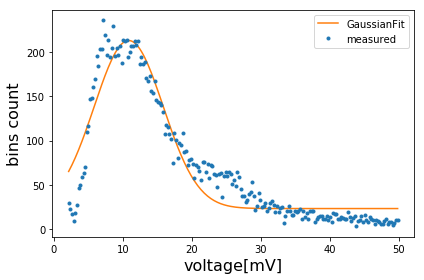

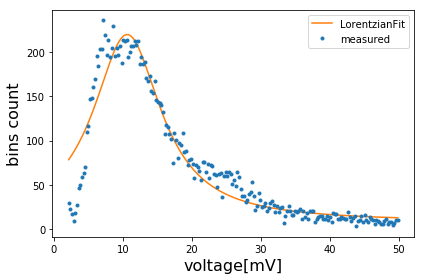

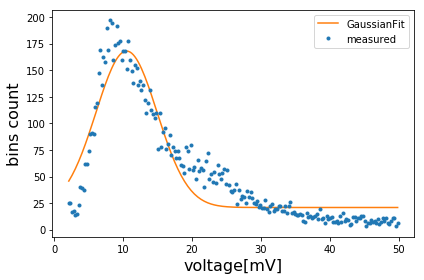

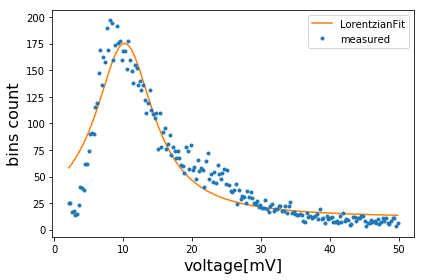

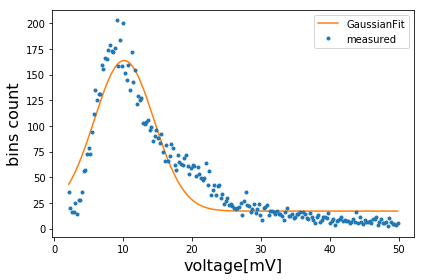

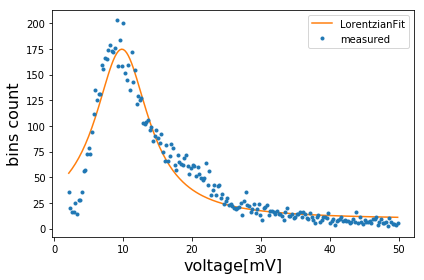

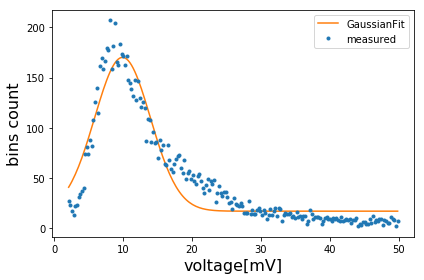

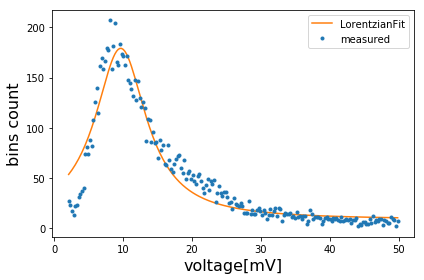

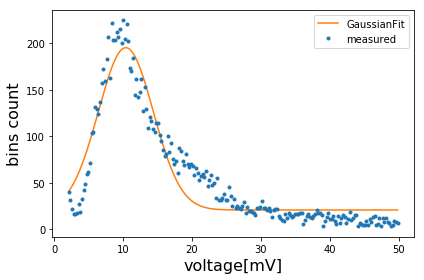

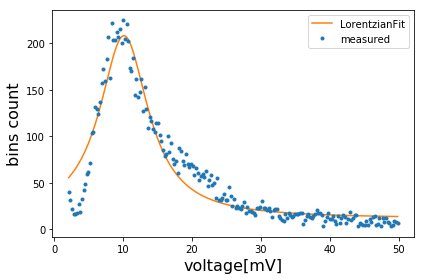

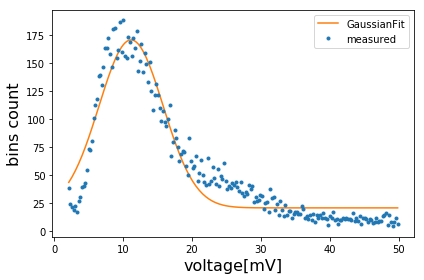

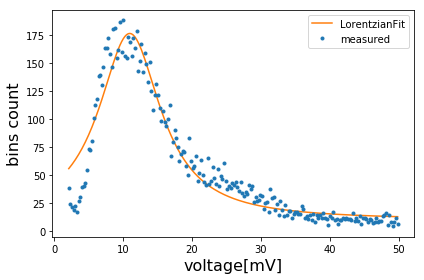

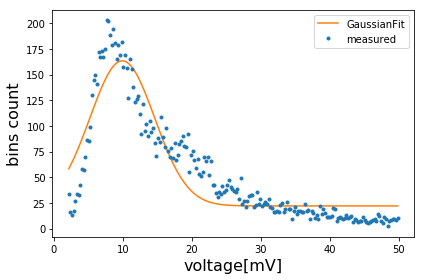

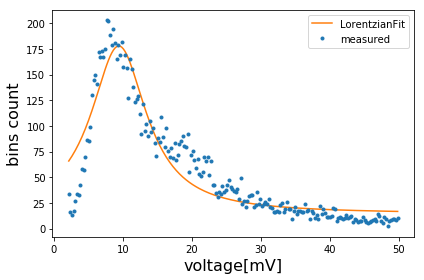

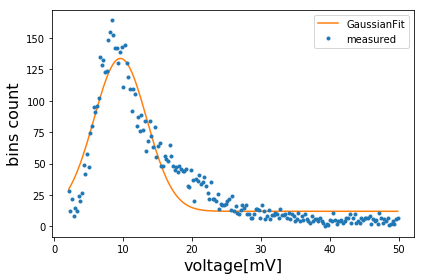

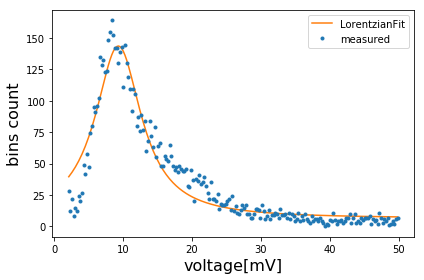

In [10]:
##実行    
avg = 5
minth = 2
maxth = 50
start = 51
fs = 15*pow(10,6) 

dir0 = os.getcwd()
path =  filename[0].split('_',)[-1] + '_' + str(start) + '-' + str(avg) + "avg_th" + str(minth) + '-' + str(maxth)
path = os.path.join(dir0,path)
res1 = os.path.exists(path)
res2 = dir0 == path
if (res1==0)&(res2==0):
    os.mkdir(path)
os.chdir(path)

models = []
for i,df in enumerate(dlist):
    model = hist(df, fs=fs, filename=filename[i], start=start, minth=minth, maxth=maxth, avg=avg, save=False)
    models.append(model)
    
#resultL,resultG = toCSV(models,save=False)
os.chdir(dir0)
#resultG.head()

In [9]:
models2 = models

In [26]:
d30 = pd.DataFrame(models2[3].count,index=models2[3].level)
d31 = pd.DataFrame(models[3].count,index=models[3].level)

In [27]:
d3 = d30.add(d31,fill_value=0)

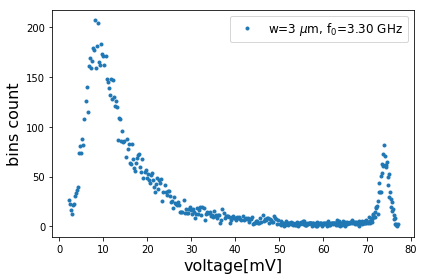

In [39]:
fig, ax = plt.subplots()
ax.plot(d3,marker='.',linestyle='None')
ax.set_xlabel('voltage[mV]',fontsize=16)
ax.set_ylabel('bins count',fontsize=16)
ax.legend(['w=3 $\mu$m, f$\it_{0}$=3.30 GHz'],fontsize=12)
fig.tight_layout()
plt.savefig('hist_all3p30.png')
plt.show()

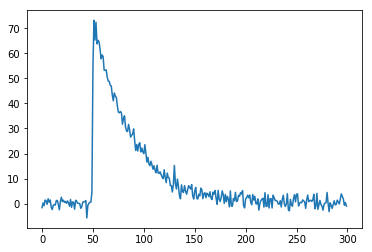

In [311]:
models[6].df.iloc[:,3].plot()

In [17]:
os.getcwd()

'\\\\133.38.162.214\\ctrl\\ミーティング資料（成瀬研）\\20190912_frontside\\20190912\\table\\57_51-5avg_th3-50'

In [241]:
9558/1872

5.105769230769231

In [34]:
models[3].name.split('-',1)[0].replace('p','.')

'3.304GHz'

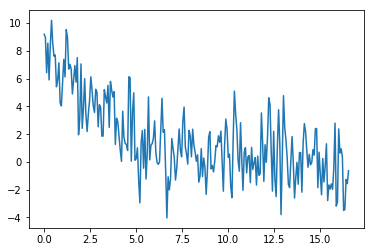

In [267]:
fig,ax = plt.subplots()
x = models[3].time[:-51] * pow(10,6)
y = models[3].df.iloc[51:,70]
ax.plot(x,y)

In [293]:
def pulse(t,a,b):
    y = a * np.exp(-1*t/b)
    return(y)

In [294]:
yy = pulse(x[:-51],max(y),pow(10,-6))

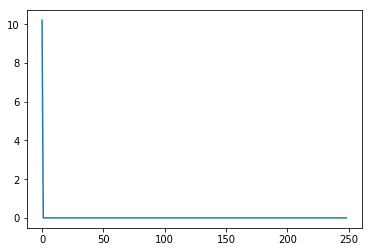

In [296]:
plt.plot(yy)

In [282]:
list(map(lambda t,a,b:a*np.exp(-1*t/b),x[:-51],init[0]*np.ones(x[:-51].size),init[1]*np.ones(x[:-51].size)))

[10.2079,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


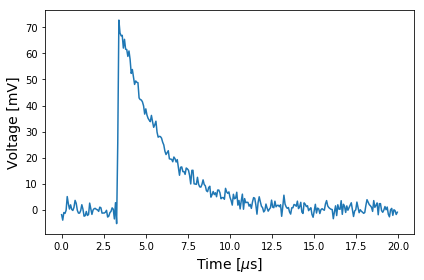

In [313]:
import scipy.optimize

fig,ax = plt.subplots()
x = models[6].time * pow(10,6)
y = models[6].df.iloc[:,70]
init = np.array([0.0000025])
#param, pcov = scipy.optimize.curve_fit(lambda t,b:max(y)*np.exp(-1*t/b),x[:-51],y[51:],init)

ax.plot(x,y)
ax.set_ylabel('Voltage [mV]',fontsize=14)
ax.set_xlabel('Time [$\mu$s]',fontsize=14)
#ax.set_xlim(0,20)
fig.tight_layout()
plt.savefig('sample73mv.png')
plt.show()

In [289]:
param

array([2.5e-06])

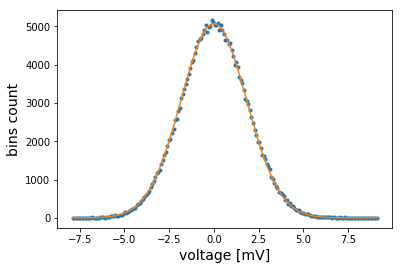

In [62]:
fig1,ax1 = plt.subplots()
y = models[2].nCount
x = models[2].nLevel
fit = models[2].noise.best_fit
ax1.scatter(x,y,marker='.')
ax1.plot(x,fit,color='tab:orange')
ax1.set_ylabel('bins count',fontsize=14)
ax1.set_xlabel('voltage [mV]',fontsize=14)
plt.savefig('noiseHisto[2].png')

## パラメータをチューニングして再フィット

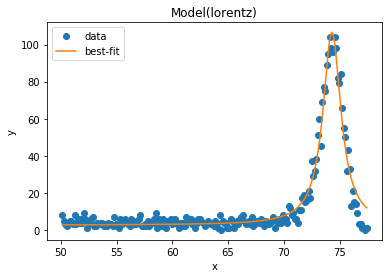

In [173]:
models[0].lfit.plot_fit()

In [180]:
th = models[0].lfit.values['fwhm']
pars = models[0].pars
model2 = models

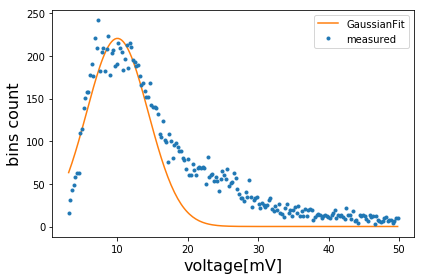

In [81]:
def paramTune1(model,th,pars):
    pars = model.gfit.params
    pars['c'].set(value=0.1,vary=False)
    mask = model.level < (model.level.min()+0.6*th)
    mod, model.gfit = model.gaussfit(x=model.level[mask],y=model.count[mask],pars=pars,save=True)
    return model.gfit
model2[2].gfit = paramTune1(model2[0],1.5*th,pars)

In [179]:
tuned = pd.DataFrame.from_dict(model2[2].gfit.values,orient='index').T
tuned.head()
tuned.to_csv('tuned_gfit2large.csv')

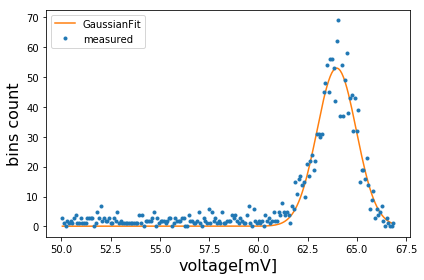

In [198]:
def paramTune2(model,th,pars):
    pars = model.gfit.params
    pars['c'].set(value=0.1,vary=False)
    mask = model.level > (model.level.max()-th)
    mod, model.gfit = model.gaussfit(x=model.level[mask],y=model.count[mask],pars=pars,save=True)
    return model.gfit
model2[2].gfit = paramTune2(model2[2],3*th,pars)

{'amplitude': 4107.103767783221,
 'center': 0.008319609800143991,
 'sigma': 1.846820084216814,
 'fwhm': 4.348928870715438,
 'height': 887.1992661661712}

In [203]:
models[2].gfit

In [201]:
toCSV(models2)

(         Noise[mV]  Signal[mV]        S/N  FWHM[mV]  Resolution
 fr[GHz]                                                        
 3.528     1.739952   74.308504  42.707219  1.957778   37.955536
 3.466     1.862238   79.158971  42.507440  2.214424   35.746983
 3.615     1.846820   63.975273  34.640772  1.903001   33.618100
 3.304     1.868977   73.932339  39.557656  1.970978   37.510493
 3.688     1.894374   73.896273  39.008289  2.058594   35.896476
 3.338     1.961038   97.539816  49.738874  2.720561   35.852835
 3.755     1.764635   68.609960  38.880550  2.143676   32.005746
 3.249     1.877132   58.453445  31.139758  1.957651   29.858977,
          Noise[mV]  signal[mV]        S/N      FWHM  Resolution
 fr[GHz]                                                        
 3.528     1.739952   74.289378  42.707219  2.499119   37.955536
 3.466     1.862238   79.140228  42.507440  2.690169   35.746983
 3.615     1.846820   63.975173  34.640772  2.347859   33.618100
 3.304     1.868977   73

## サンプルコード